# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

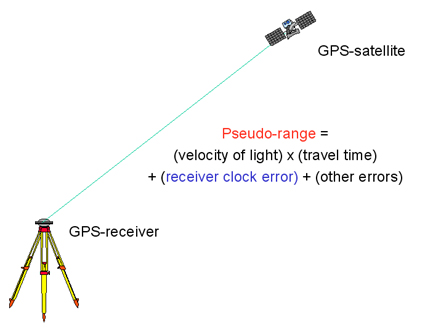

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
df_pseudorange = pd.read_excel('/content/sample_data/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/sample_data/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [3]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [4]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [5]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [6]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    """
    Computes the cost as the sum of squared residuals between measured and predicted pseudoranges.

    Parameters:
    r_pos (np.array): Receiver's position in ECEF coordinates.
    cdT (float): Receiver's clock offset.
    s_pos (np.array): Array of satellite positions in ECEF coordinates.
    pseudorange (np.array): Observed pseudoranges.

    Returns:
    float: Sum of squared residuals (cost).
    """
    # Calculate geometric distance using the euclidean_norm function
    geometric_distance = euclidean_norm(r_pos, s_pos)

    # Predicted pseudorange with clock offset
    predicted_pseudorange = geometric_distance + cdT

    # Compute residuals (difference between observed and predicted pseudoranges)
    residuals = pseudorange - predicted_pseudorange

    # Sum of squared residuals
    L = np.sum(residuals ** 2)

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [7]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)

def gradient(r_pos, cdT, s_pos, pseudorange):
    """
    Computes the gradient of the cost function with respect to the receiver's position (x_r, y_r, z_r) and clock offset (cdT).

    Parameters:
    r_pos (np.array): Receiver's position in ECEF coordinates (x_r, y_r, z_r).
    cdT (float): Receiver's clock offset.
    s_pos (np.array): Array of satellite positions in ECEF coordinates.
    pseudorange (np.array): Observed pseudoranges.

    Returns:
    np.array: Gradient of the cost function as a 1D array with 4 elements [dL_dx, dL_dy, dL_dz, dL_dcdT].
    """
    # Calculate the geometric distance between the receiver and each satellite
    geometric_distance = euclidean_norm(r_pos, s_pos)

    # Predicted pseudorange with clock offset
    predicted_pseudorange = geometric_distance + cdT

    # Residuals (difference between observed and predicted pseudoranges)
    residuals = pseudorange - predicted_pseudorange

    # Calculate partial derivatives with respect to each coordinate and clock offset
    dL_dx = -2 * np.sum(residuals * (r_pos[0] - s_pos[:, 0]) / geometric_distance)
    dL_dy = -2 * np.sum(residuals * (r_pos[1] - s_pos[:, 1]) / geometric_distance)
    dL_dz = -2 * np.sum(residuals * (r_pos[2] - s_pos[:, 2]) / geometric_distance)
    dL_dcdT = -2 * np.sum(residuals)

    # Combine partial derivatives into a gradient vector
    grad = np.array([dL_dx, dL_dy, dL_dz, dL_dcdT])

    return grad


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [8]:
# Gradient Descent Implementation for optimizing the receiver's position and clock offset
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):
    """
    Performs gradient descent to minimize the cost function and find the optimized estimates
    for the receiver's position (x_r, y_r, z_r) and clock offset (cdT).

    Parameters:
    pseudorange (np.array): Observed pseudoranges from the satellites.
    s_pos (np.array): Satellite positions in ECEF coordinates.
    learning_rate (float): Learning rate for gradient descent. Default is 0.01.
    max_iters (int): Maximum number of iterations. Default is 100000.
    tolerance (float): Convergence tolerance. Default is 1e-6.

    Returns:
    np.array: Optimized estimates as a 1D numpy array [x_r, y_r, z_r, cdT].
    """
    global steps_count

    # Initialize the estimates as zeros
    X = np.array([0.0, 0.0, 0.0, 0.0])

    for iteration in range(max_iters):
        r_pos = X[:3]  # Receiver position (x_r, y_r, z_r)
        cdT = X[3]     # Receiver clock offset

        # compute the cost in the current step
        # (1 mark)
        # Compute the cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        # Compute the gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # update estimates
        # (1 mark)
        # Update estimates using the gradient and learning rate
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        # Compute the new cost after updating estimates
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Break the loop if the change in cost is below the tolerance
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost, gradients, and errors
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)

    return X


### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [9]:
# Call the gradient_descent function to optimize the parameters using default hyperparameters
optimized_params = gradient_descent(pseudorange, sat_pos)

# Calculate the final position error of the receiver by comparing optimized and ground truth positions
final_position_error = optimized_params[:3] - GroundTruth

# Final cost value
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)

# Final gradient values
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)


print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Error of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Error of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.19709343841564
Final Gradient Values: [ 0.00048759  0.0027168  -0.00834987 -0.00473382]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

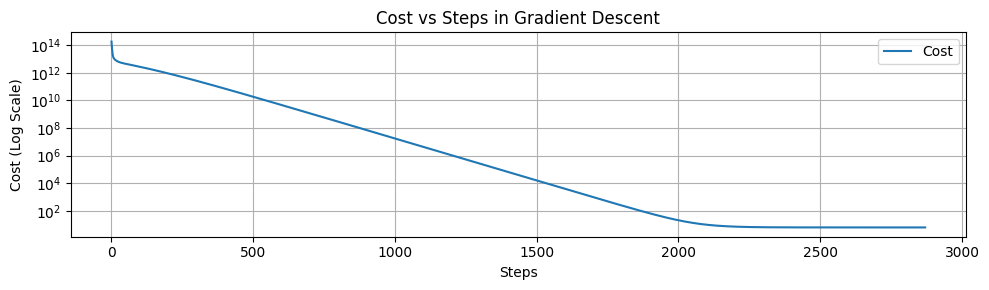


The plot shows a decreasing pattern in the cost as the steps progress, indicating that the gradient descent algorithm
is converging towards the minimum cost. The sharp initial drop suggests a fast descent in the early iterations,
while the gradual flattening towards the end indicates convergence as the algorithm approaches the optimal parameters.



In [10]:
# Plot cost vs steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.semilogy(arr_cost, label="Cost")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost (Log Scale)")
ax.set_title("Cost vs Steps in Gradient Descent")
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

# Comment on the pattern
comment = """
The plot shows a decreasing pattern in the cost as the steps progress, indicating that the gradient descent algorithm
is converging towards the minimum cost. The sharp initial drop suggests a fast descent in the early iterations,
while the gradual flattening towards the end indicates convergence as the algorithm approaches the optimal parameters.
"""
print(comment)


### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

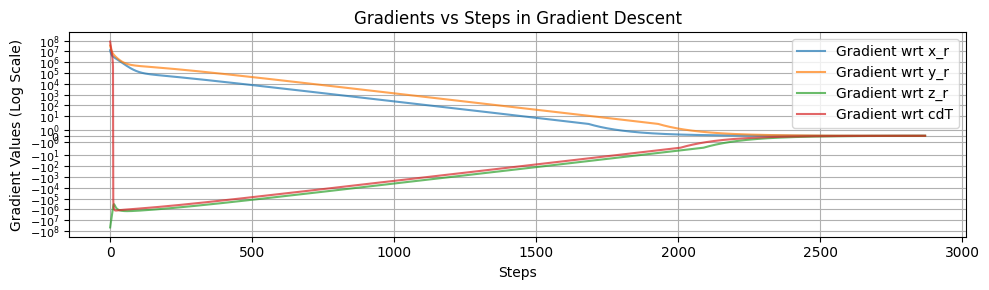


The plot shows a decreasing trend in the gradient values over the steps, indicating that the gradient descent algorithm
is converging toward a minimum. The rapid decline in the early iterations suggests effective initial corrections to the
estimates, while the smaller adjustments in later steps imply the algorithm is fine-tuning close to the optimal solution.
The symlog scale on the y-axis helps visualize both large and small gradients effectively, showing how they approach zero
as the algorithm nears convergence.



In [12]:
# Plot gradients vs steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Convert arr_grad to a numpy array for easier indexing by axis
arr_grad_np = np.array(arr_grad)

# Plot each gradient component with symlog scale on y-axis
ax.plot(arr_grad_np[:, 0], label="Gradient wrt x_r", alpha=0.7)
ax.plot(arr_grad_np[:, 1], label="Gradient wrt y_r", alpha=0.7)
ax.plot(arr_grad_np[:, 2], label="Gradient wrt z_r", alpha=0.7)
ax.plot(arr_grad_np[:, 3], label="Gradient wrt cdT", alpha=0.7)
ax.set_yscale("symlog")
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient Values (Log Scale)")
ax.tick_params(axis='y', labelsize=8)
ax.set_title("Gradients vs Steps in Gradient Descent")
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
comment = """
The plot shows a decreasing trend in the gradient values over the steps, indicating that the gradient descent algorithm
is converging toward a minimum. The rapid decline in the early iterations suggests effective initial corrections to the
estimates, while the smaller adjustments in later steps imply the algorithm is fine-tuning close to the optimal solution.
The symlog scale on the y-axis helps visualize both large and small gradients effectively, showing how they approach zero
as the algorithm nears convergence.
"""
print(comment)


### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

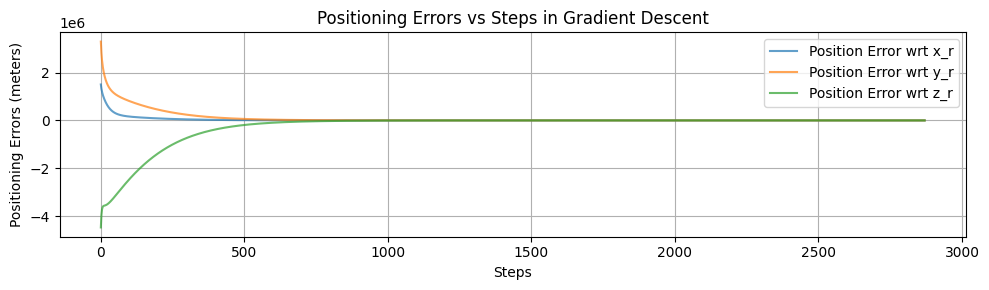


The positioning error plot shows a decrease in errors for each positional component (x_r, y_r, z_r) over the steps.
Initially, there are larger fluctuations as the gradient descent algorithm makes significant adjustments to approach
the optimal solution. As the steps progress, the errors gradually decrease and stabilize close to zero, indicating
that the receiver's estimated position converges to the true position. This steady decline in positioning errors
demonstrates successful convergence and accuracy in the estimated position.



In [13]:
# Plot positioning errors vs steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Convert arr_err to a numpy array for easier indexing by axis
arr_err_np = np.array(arr_err)

# Plot each position error component over steps
ax.plot(arr_err_np[:, 0], label="Position Error wrt x_r", alpha=0.7)
ax.plot(arr_err_np[:, 1], label="Position Error wrt y_r", alpha=0.7)
ax.plot(arr_err_np[:, 2], label="Position Error wrt z_r", alpha=0.7)
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Errors (meters)")
ax.set_title("Positioning Errors vs Steps in Gradient Descent")
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
comment = """
The positioning error plot shows a decrease in errors for each positional component (x_r, y_r, z_r) over the steps.
Initially, there are larger fluctuations as the gradient descent algorithm makes significant adjustments to approach
the optimal solution. As the steps progress, the errors gradually decrease and stabilize close to zero, indicating
that the receiver's estimated position converges to the true position. This steady decline in positioning errors
demonstrates successful convergence and accuracy in the estimated position.
"""
print(comment)


# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [14]:
# Set learning rate to 0.01 and reinitialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Run gradient descent with a learning rate of 0.01
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000)

# Calculate final metrics for learning rate 0.01
final_position_error_2 = optimized_params_2[:3] - GroundTruth
final_cost_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
final_gradient_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)

# Print the results for learning rate 0.01
print("Results with Learning Rate 0.01:")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Error of Receiver:", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)

Converged!
Results with Learning Rate 0.01:
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Error of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.19709343841564
Final Gradient Values: [ 0.00048759  0.0027168  -0.00834987 -0.00473382]


In [15]:
# Set learning rate to 0.001 and reinitialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Run gradient descent with a learning rate of 0.001
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=200000)

# Calculate final metrics for learning rate 0.001
final_position_error_3 = optimized_params_3[:3] - GroundTruth
final_cost_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
final_gradient_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)

# Print the results for learning rate 0.001
print("\nResults with Learning Rate 0.001:")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)
print("Final Position Error of Receiver:", final_position_error_3)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_3)
print("Final Gradient Values:", final_gradient_3)

Converged!

Results with Learning Rate 0.001:
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45048680e+00]
Final Position Error of Receiver: [-3.0626223  -2.34752101  3.77518774]
Number of Steps Taken for Convergence: 27145
Final Cost Value: 6.197741842276456
Final Gradient Values: [ 0.0015476   0.00862312 -0.02650245 -0.01502497]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

**Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)**

When changing the learning rate from 0.01 to 0.001:

*   The convergence time (number of steps) increases significantly. With a learning rate of 0.01, the algorithm converges in about 2871 steps, whereas with a learning rate of 0.001, it requires 27145 steps.

*   Both learning rates ultimately reach a similar final cost and similar optimized parameters, demonstrating that the smaller learning rate provides a stable, gradual convergence. However, the higher learning rate (0.01) achieves these results faster without sacrificing accuracy.

*   This highlights a key trade-off: lower learning rates are more cautious, leading to a more stable but slower approach, while higher learning rates speed up convergence but can sometimes risk overshooting, though in this case, 0.01 did not cause such issues.

**Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)**




*   **Least Squares Estimation (LSE)** is an analytical method that minimizes the sum of squared errors directly, finding the best-fit parameters through algebraic solutions (e.g., matrix operations). LSE works efficiently with linear models or when the cost function can be directly minimized.
*   **Gradient Descent** is an iterative optimization technique used to minimize the cost function, especially useful for complex or non-linear functions where direct solutions aren’t feasible. Gradient descent incrementally adjusts parameters in the direction of the negative gradient of the cost function, requiring multiple steps to reach an approximate minimum.


**Based on results and methodology:**


*   Gradient Descent, as implemented here, enables fine-tuning of parameters (position and clock offset) by iteratively reducing the cost function. Although it requires setting hyperparameters (learning rate, iteration limit), it effectively reaches an accurate solution in the absence of a closed-form solution, as would be used in LSE.
*   LSE would not be practical in this scenario due to the non-linear relationship between satellite positions, pseudoranges, and the receiver’s position, making Gradient Descent a more suitable choice for achieving accurate results iteratively.



---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

# TO DO: display sizes of X and y (1 mark)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [ ]:
# TO DO: Check the class distribution of y (2 mark)


# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data


# TO DO: display sizes of X_small and y_small (2 mark)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---